# diffusion

> Fill in a module description here

In [ ]:
#| default_exp diffusion

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

In [ ]:
#| export
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [ ]:
from fastcore.foundation import L

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([8, 3, 1, 6, 8, 8, 6, 3])


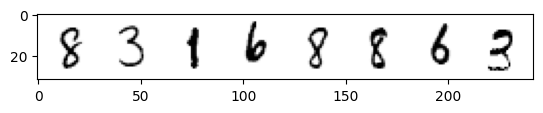

In [ ]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

### Why Diffusion Process

The idea of diffusion is we sequentially add more noise to an image and then lets the model to predict what's noise it need to remove to get back the original image

### Diffusion Process

In [ ]:
def show_img(img):
    return plt.imshow(img, cmap='Greys');

In [ ]:
img = next(iter(train_dataloader))[0][1][0]

<matplotlib.image.AxesImage>

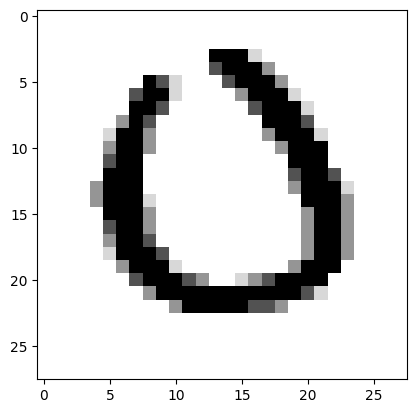

In [ ]:
show_img(img)

In [ ]:
noise = torch.randn_like(img)

<matplotlib.image.AxesImage>

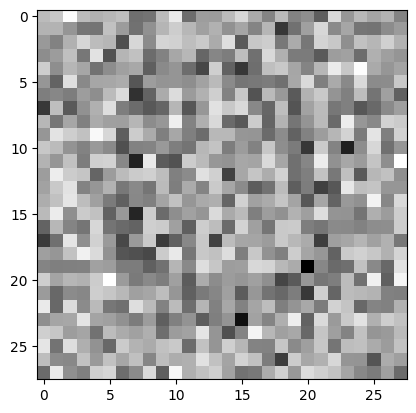

In [ ]:
show_img(img + noise)

In [ ]:
#| exports
def corrupt(img, amount):
    noise = torch.randn_like(img)
    return (1-amount)*img + noise * amount

In [ ]:
amounts = torch.linspace(0, 1, steps=10)

In [ ]:
amounts

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])

In [ ]:
corrupt_images = []

In [ ]:
for amount in amounts:
    # ipdb.set_trace()
    corrupt_images.append(corrupt(img, amount))

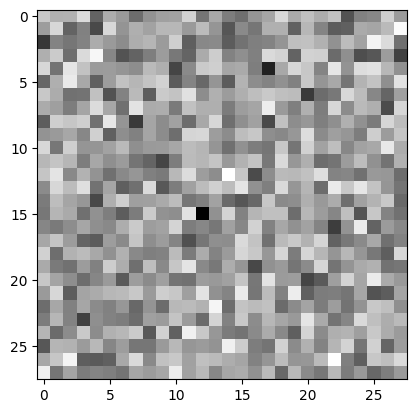

In [ ]:
for corrupt_imgage in corrupt_images:
    show_img(corrupt_imgage)

In [ ]:
noise_steps

[]

In [ ]:
torchvision.utils.make_grid(corrupt_images).shape

torch.Size([10, 28, 28])

<matplotlib.image.AxesImage>

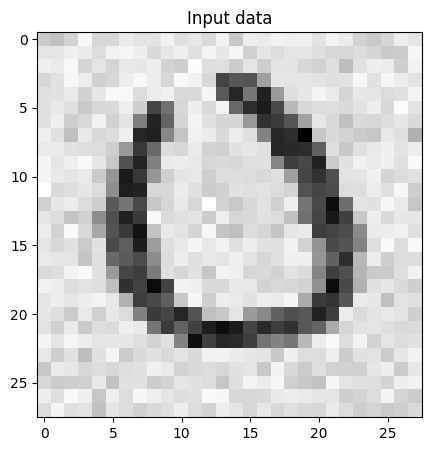

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))

axs.set_title('Input data')
axs.imshow(torchvision.utils.make_grid(corrupt_images)[0], cmap='Greys')
axs.imshow(torchvision.utils.make_grid(corrupt_images)[1], cmap='Greys')

In [ ]:
axs.imshow(torchvision.utils.make_grid(corrupt_images)[5], cmap='Greys')

<matplotlib.image.AxesImage>